# Supervised Learning Music Genre Classification

## Import Statements

Start by importing necessary libraries.

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, learning_curve, validation_curve, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import soundfile as sf
import joblib

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


## Import Data from prepared CSV

In [2]:
data = pd.read_csv('all_genres_audio_features.csv')
data = data.drop(columns= ['filename','start','end']) 

genres = ["blues", "classical", "country", "disco", "hiphop", "jazz", "metal", "pop", "reggae", "rock"]

data.shape

(990, 58)

Check for duplicates. 

In [3]:
def check_duplicates_or_nulls(data):
    duplicates = data.duplicated().sum() > 0
    nulls = data.isnull().sum().sum() > 0
    return duplicates or nulls

if check_duplicates_or_nulls(data):
    print('Duplicates or null values found in data')
else:
    print('No duplicates or null values found in data')

Duplicates or null values found in data


Deal with strings in features

In [4]:
# Clean the 'tempo' column
data['tempo'] = data['tempo'].str.strip('[]').astype(float)

# Verify the changes
data.describe(include='all')

,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,rolloff_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,genre
count,990.000000,990.000000,990.000000,990.000000,990.000000,9.900000e+02,990.000000,990.000000,990.000000,9.900000e+02,...,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,blues
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100
mean,0.378526,0.086380,0.130414,0.003054,2199.327355,4.702095e+05,2239.681058,137032.649397,4565.584867,1.843171e+06,...,60.857603,-3.977718,62.761515,0.510834,63.875337,-2.332108,66.381000,-1.107886,70.208984,NaN
std,0.081866,0.007767,0.065648,0.003650,716.918309,4.021494e+05,527.173141,96744.108324,1576.215437,1.429330e+06,...,33.889547,4.565682,33.586670,3.883969,34.514212,3.769515,37.321348,3.849626,45.418791,NaN
min,0.171770,0.044578,0.005270,0.000004,570.150688,7.957773e+03,899.979779,11160.012382,749.528801,1.480754e+04,...,9.205502,-17.235107,13.846979,-11.985029,15.395741,-18.505476,13.382758,-19.933723,7.877422,NaN
25%,0.319397,0.082381,0.086429,0.000940,1623.214609,1.840840e+05,1903.010596,67181.287307,3377.483743,7.690237e+05,...,40.488236,-7.241572,40.969441,-2.011947,41.861624,-4.696787,41.768796,-3.377763,42.257666,NaN
50%,0.383055,0.086644,0.120666,0.001817,2208.737431,3.392128e+05,2218.084461,112497.079762,4658.484331,1.467297e+06,...,52.461257,-4.076550,54.800145,0.668484,55.169390,-2.393830,57.557110,-1.185065,59.217588,NaN
75%,0.435470,0.091295,0.175362,0.003575,2685.204362,6.151319e+05,2575.647770,181960.326743,5525.670754,2.560563e+06,...,71.635835,-0.849765,75.093534,3.126128,76.165089,0.156752,78.933091,1.287499,85.776141,NaN


## Begin Preprocessing

Apply the low pass filter through use of a moving average with a window size of 3.

In [5]:
def apply_moving_average_filter(df, window_size=3):
    feature_columns = df.columns.difference(['genre'])
    df[feature_columns] = df[feature_columns].rolling(window=window_size, min_periods=1).mean()
    return df

data = apply_moving_average_filter(data)

## Shuffle and Split data

Split data into training and testing sets (70/30).

In [6]:
# Split the data into features and target variable
X = np.array(data.iloc[:, :-1], dtype=float)
y = data.iloc[:, -1]

# Split the dataset with 70% for training set and 30% for test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

## Normalize the data set and encode the labels

In [7]:
# Scale the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Encode the target labels
encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_test = encoder.transform(y_test)

## Learning curves 

Learning curve function

In [8]:
def plot_learning_curve(estimator, title, X, y, cv=None, n_jobs=None):
    plt.figure()
    plt.title(title)
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=np.linspace(.1, 1.0, 5))
    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.legend(loc="best")
    plt.grid()
    plt.show()

## Model initialization and hyper parameter tuning

Define function for model train and evaluation

In [9]:
# Define the model training and evaluation function with cross-validation
def train_and_evaluate_model(model, param_grid):
    grid_search = GridSearchCV(model, param_grid, cv=StratifiedKFold(n_splits=5), scoring='accuracy', error_score='raise')
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_

    # Cross-validation
    cv_scores = cross_val_score(best_model, X_train, y_train, cv=StratifiedKFold(n_splits=5), scoring='accuracy')
    print(f'Cross-validation scores: {cv_scores}')
    print(f'Mean cross-validation score: {np.mean(cv_scores)}')

    y_pred = best_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, target_names=encoder.classes_)
    return best_model, accuracy, report


Random Forest Model.

Cross-validation scores: [0.90647482 0.92805755 0.92805755 0.94927536 0.9057971 ]
Mean cross-validation score: 0.923532478365134
Random Forest Accuracy: 0.9090909090909091
Random Forest Classification Report:
               precision    recall  f1-score   support

       blues       0.92      1.00      0.96        34
   classical       1.00      1.00      1.00        18
     country       1.00      0.91      0.95        34
       disco       0.80      0.80      0.80        35
      hiphop       0.88      0.81      0.84        26
        jazz       0.94      0.97      0.95        30
       metal       1.00      0.92      0.96        26
         pop       0.94      0.91      0.92        33
      reggae       0.82      1.00      0.90        27
        rock       0.88      0.82      0.85        34

    accuracy                           0.91       297
   macro avg       0.92      0.91      0.91       297
weighted avg       0.91      0.91      0.91       297



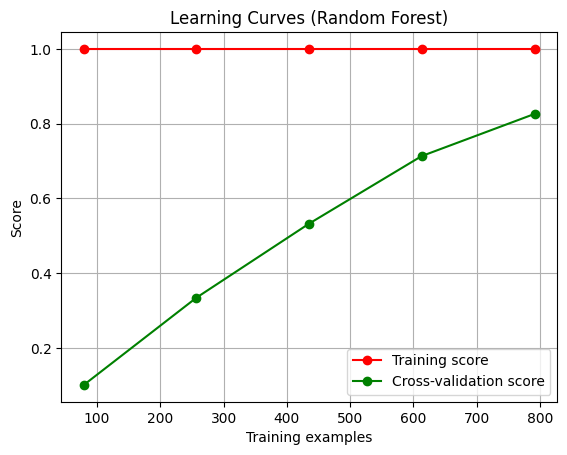

In [10]:
rf_param_grid = {
    'n_estimators': [100, 250, 1000],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
rf_model = RandomForestClassifier()
rf_best_model, rf_accuracy, rf_report = train_and_evaluate_model(rf_model, rf_param_grid)
print("Random Forest Accuracy:", rf_accuracy)
print("Random Forest Classification Report:\n", rf_report)

plot_learning_curve(rf_best_model, "Learning Curves (Random Forest)", X, y, cv=5)

Support Vector Machine Model. 

Cross-validation scores: [0.94964029 0.95683453 0.96402878 0.97826087 0.92753623]
Mean cross-validation score: 0.9552601397143154
SVM Accuracy: 0.9696969696969697
SVM Classification Report:
               precision    recall  f1-score   support

       blues       1.00      1.00      1.00        34
   classical       0.95      1.00      0.97        18
     country       0.97      0.94      0.96        34
       disco       0.92      1.00      0.96        35
      hiphop       1.00      1.00      1.00        26
        jazz       0.97      1.00      0.98        30
       metal       1.00      0.92      0.96        26
         pop       1.00      0.91      0.95        33
      reggae       0.93      1.00      0.96        27
        rock       0.97      0.94      0.96        34

    accuracy                           0.97       297
   macro avg       0.97      0.97      0.97       297
weighted avg       0.97      0.97      0.97       297



/Users/isaiah/opt/anaconda3/envs/ELEC292/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:547: FitFailedWarning: 
5 fits failed out of a total of 25.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/isaiah/opt/anaconda3/envs/ELEC292/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/isaiah/opt/anaconda3/envs/ELEC292/lib/python3.9/site-packages/sklearn/base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/Users/isaiah/opt/anaconda3/envs/ELEC292/lib/python3.9/site-packages/sklearn/svm/_bas

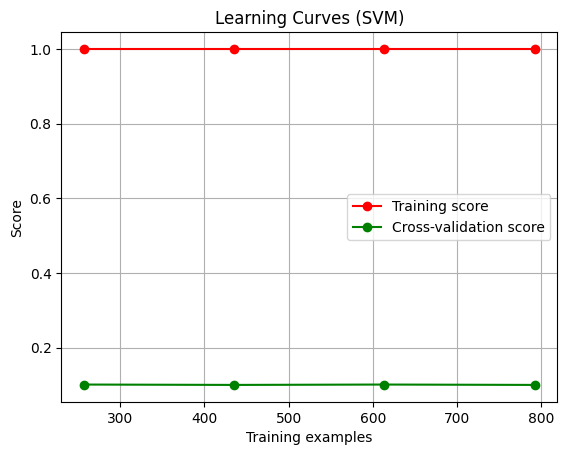

In [11]:
svm_param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
    'kernel': ['rbf', 'linear']
}
svm_model = SVC()
svm_best_model, svm_accuracy, svm_report = train_and_evaluate_model(svm_model, svm_param_grid)
print("SVM Accuracy:", svm_accuracy)
print("SVM Classification Report:\n", svm_report)

plot_learning_curve(svm_best_model, "Learning Curves (SVM)", X, y, cv=5)

Gradient Boost Model.

Cross-validation scores: [0.82733813 0.92086331 0.91366906 0.89855072 0.87681159]
Mean cross-validation score: 0.8874465644875403
Gradient Boosting Accuracy: 0.8855218855218855
Gradient Boosting Classification Report:
               precision    recall  f1-score   support

       blues       0.88      0.88      0.88        34
   classical       1.00      0.94      0.97        18
     country       0.86      0.94      0.90        34
       disco       0.75      0.94      0.84        35
      hiphop       1.00      0.81      0.89        26
        jazz       0.90      0.93      0.92        30
       metal       1.00      0.92      0.96        26
         pop       1.00      0.85      0.92        33
      reggae       0.83      0.93      0.88        27
        rock       0.81      0.74      0.77        34

    accuracy                           0.89       297
   macro avg       0.90      0.89      0.89       297
weighted avg       0.89      0.89      0.89       297



/Users/isaiah/opt/anaconda3/envs/ELEC292/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:547: FitFailedWarning: 
5 fits failed out of a total of 25.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/isaiah/opt/anaconda3/envs/ELEC292/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/isaiah/opt/anaconda3/envs/ELEC292/lib/python3.9/site-packages/sklearn/base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/Users/isaiah/opt/anaconda3/envs/ELEC292/lib/python3.9/site-packages/sklearn/ensemble

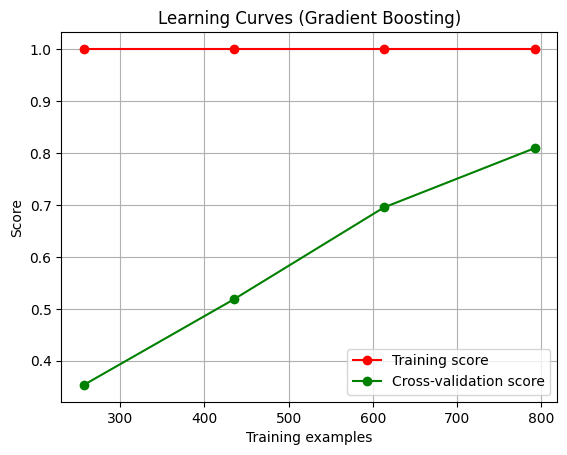

In [12]:
gb_param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.5],
    'max_depth': [3, 5, 7]
}
gb_model = GradientBoostingClassifier()
gb_best_model, gb_accuracy, gb_report = train_and_evaluate_model(gb_model, gb_param_grid)
print("Gradient Boosting Accuracy:", gb_accuracy)
print("Gradient Boosting Classification Report:\n", gb_report)

plot_learning_curve(gb_best_model, "Learning Curves (Gradient Boosting)", X, y, cv=5)


KNeighbours Model. 

/Users/isaiah/opt/anaconda3/envs/ELEC292/lib/python3.9/site-packages/threadpoolctl.py:1186: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


Cross-validation scores: [0.91366906 0.96402878 0.94964029 0.97101449 0.9057971 ]
Mean cross-validation score: 0.9408299447398601
KNeighbors Accuracy: 0.9191919191919192
KNeighbors Classification Report:
               precision    recall  f1-score   support

       blues       1.00      0.97      0.99        34
   classical       0.90      1.00      0.95        18
     country       0.89      0.94      0.91        34
       disco       0.80      0.94      0.87        35
      hiphop       0.89      0.92      0.91        26
        jazz       0.93      0.90      0.92        30
       metal       1.00      0.88      0.94        26
         pop       1.00      0.88      0.94        33
      reggae       0.92      0.89      0.91        27
        rock       0.91      0.88      0.90        34

    accuracy                           0.92       297
   macro avg       0.92      0.92      0.92       297
weighted avg       0.92      0.92      0.92       297



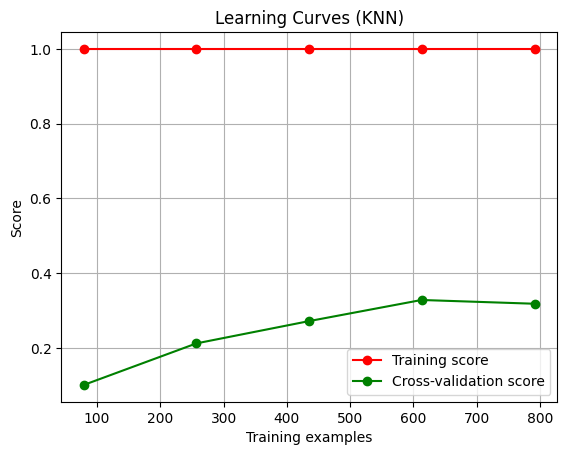

In [13]:
knn_param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11, 13],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}
knn_model = KNeighborsClassifier()
knn_best_model, knn_accuracy, knn_report = train_and_evaluate_model(knn_model, knn_param_grid)
print("KNeighbors Accuracy:", knn_accuracy)
print("KNeighbors Classification Report:\n", knn_report)

plot_learning_curve(knn_best_model, "Learning Curves (KNN)", X, y, cv=5)

Logistic Regression

/Users/isaiah/opt/anaconda3/envs/ELEC292/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/isaiah/opt/anaconda3/envs/ELEC292/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/isaiah/opt/anaconda3/envs/ELEC292/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/isaiah/opt/anaconda3/envs/ELEC292/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/isaiah/opt/anaconda3/envs/ELEC292/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not conver

Cross-validation scores: [0.92805755 0.91366906 0.92805755 0.95652174 0.9057971 ]
Mean cross-validation score: 0.9264206026483162
Logistic Regression Accuracy: 0.9427609427609428
Logistic Regression Classification Report:
               precision    recall  f1-score   support

       blues       0.97      0.97      0.97        34
   classical       0.95      1.00      0.97        18
     country       0.97      0.94      0.96        34
       disco       0.87      0.97      0.92        35
      hiphop       0.95      0.77      0.85        26
        jazz       0.97      1.00      0.98        30
       metal       1.00      0.96      0.98        26
         pop       1.00      0.97      0.98        33
      reggae       0.83      0.93      0.88        27
        rock       0.94      0.91      0.93        34

    accuracy                           0.94       297
   macro avg       0.95      0.94      0.94       297
weighted avg       0.95      0.94      0.94       297



/Users/isaiah/opt/anaconda3/envs/ELEC292/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:547: FitFailedWarning: 
5 fits failed out of a total of 25.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/isaiah/opt/anaconda3/envs/ELEC292/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/isaiah/opt/anaconda3/envs/ELEC292/lib/python3.9/site-packages/sklearn/base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/Users/isaiah/opt/anaconda3/envs/ELEC292/lib/python3.9/site-packages/sklearn/linear_m

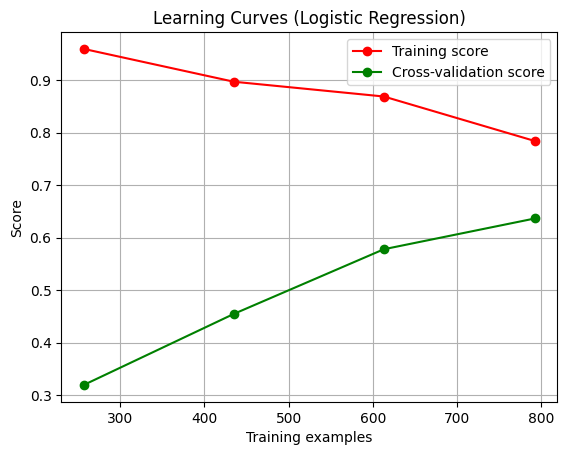

In [14]:
logreg_param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'saga'],
    'max_iter': [200, 500, 1000]
}

logreg_model = LogisticRegression()
logreg_best_model, logreg_accuracy, logreg_report = train_and_evaluate_model(logreg_model, logreg_param_grid)
print("Logistic Regression Accuracy:", logreg_accuracy)
print("Logistic Regression Classification Report:\n", logreg_report)

plot_learning_curve(logreg_best_model, "Learning Curves (Logistic Regression)", X, y, cv=5)

## Save models for future use

Use library to save model for export/import

In [15]:
# Save the best models
joblib.dump(rf_best_model, 'outputs/rf_best_model.pkl')
joblib.dump(svm_best_model, 'outputs/svm_best_model.pkl')
joblib.dump(gb_best_model, 'outputs/gb_best_model.pkl')
joblib.dump(knn_best_model, 'outputs/knn_best_model.pkl')
joblib.dump(logreg_best_model, 'outputs/logreg_best_model.pkl')

# Save the scaler and encoder
joblib.dump(scaler, 'outputs/scaler.pkl')
joblib.dump(encoder, 'outputs/encoder.pkl')

# Save the scaled data and encoded labels
joblib.dump(X_train, 'outputs/X_train.pkl')
joblib.dump(X_test, 'outputs/X_test.pkl')
joblib.dump(y_train, 'outputs/y_train.pkl')
joblib.dump(y_test, 'outputs/y_test.pkl')

['outputs/y_test.pkl']

## External validation

Preprocess the external data.

In [16]:
# Load external data
external_data = pd.read_csv('file_features.csv')
external_data = external_data.drop(columns=['filename', 'start', 'end'])

# Clean the 'tempo' column
external_data['tempo'] = external_data['tempo'].str.strip('[]').astype(float)

# Apply the same moving average filter
external_data = apply_moving_average_filter(external_data)

# Separate features
X_external = scaler.transform(np.array(external_data.iloc[:, :], dtype=float))

Apply the best models on the external data. 

In [17]:
# Load the best models
rf_best_model = joblib.load('outputs/rf_best_model.pkl')
svm_best_model = joblib.load('outputs/svm_best_model.pkl')
gb_best_model = joblib.load('outputs/gb_best_model.pkl')
knn_best_model = joblib.load('outputs/knn_best_model.pkl')
logreg_best_model = joblib.load('outputs/logreg_best_model.pkl')

# Define a function to evaluate a model on unlabeled external data
def evaluate_model_on_external_data(model, X_ext):
    y_pred = model.predict(X_ext)
    return y_pred

# Evaluate each model and gather predictions
rf_predictions = evaluate_model_on_external_data(rf_best_model, X_external)
svm_predictions = evaluate_model_on_external_data(svm_best_model, X_external)
gb_predictions = evaluate_model_on_external_data(gb_best_model, X_external)
knn_predictions = evaluate_model_on_external_data(knn_best_model, X_external)
logreg_predictions = evaluate_model_on_external_data(logreg_best_model, X_external)

# Aggregate predictions
all_predictions = np.vstack([rf_predictions, svm_predictions, gb_predictions, knn_predictions, logreg_predictions])
final_predictions = [np.bincount(row).argmax() for row in all_predictions.T]

# Map predicted numbers to genre names
final_predictions_genre = [encoder.classes_[pred] for pred in final_predictions]
print("Ensemble Predictions on External Data:")
print(final_predictions_genre)

# Save ensemble predictions
ensemble_predictions_df = pd.DataFrame(final_predictions_genre, columns=['Predicted Genre'])
ensemble_predictions_df.to_csv('outputs/ensemble_predictions.csv', index=False)

Ensemble Predictions on External Data:
['hiphop', 'hiphop', 'hiphop', 'hiphop', 'hiphop']
